# 0.Setup

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 4.0 MB 7.3 MB/s 
     |████████████████████████████████| 10.6 MB 7.6 MB/s 


In [1]:
import os
import pprint
import tempfile
from typing import Dict, Text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import manifold
from time import process_time
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import altair as alt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## __IMPORT DATASET__

In [2]:
# Load ratings/movies dataset from 100K MovieLens
dataset = ['100k', '1m', '20m', '25m']

def load_dataset(dataset='100k'):
  ratings = tfds.load(f'movielens/{dataset}-ratings', split='train')
  movies = tfds.load(f'movielens/{dataset}-movies', split='train')

  return ratings, movies

ratings, movies = load_dataset(dataset[0])

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
})
movies = movies.map(lambda x: x["movie_title"])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-10-19 15:54:19.081044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-19 15:54:19.081636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
ratings_df = tfds.as_dataframe(ratings)
movies_df = tfds.as_dataframe(movies)
movies_df.rename(columns={' ': 'movie_title'}, inplace=True)

##__SPLITTING THE DATASET__

In [3]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)

size = [100000, 1000000]
shuffled = ratings.shuffle(size[0], seed=42, reshuffle_each_iteration=False)

train_set = shuffled.take(int(0.8*size[0]))
val_set = shuffled.skip(int(0.8*size[0])).take(int(0.2*size[0]))
test_set = shuffled.skip(int(0.6*size[0])).take(int(0.2*size[0]))

movie_titles = movies.batch(int(0.1*size[0]))
user_ids = ratings.batch(1000000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

2021-10-19 15:54:24.223434: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-19 15:54:24.224595: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [19]:
unique_movie_titles.shape

(1664,)

# 1. Building Model

In [4]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    super().__init__()

    embedding_dimension = 35

    # Embedding layers of User and Movie
    # Compute embeddings for users.
    # self.user_block = tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None)
    # self.user_model = tf.keras.layers.Embedding(len(unique_user_ids) + 1, 
    #                                             embedding_dimension, 
    #                                             embeddings_regularizer='l2', 
    #                                             name='user_embedding')
    
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension, embeddings_regularizer='l2', name='user_embedding')
    ])


    # Compute embeddings for movies.
    # self.movie_block = tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None)
    # self.movie_model = tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 
    #                                              embedding_dimension, 
    #                                              embeddings_regularizer='l2', 
    #                                              name='movie_embedding')
    
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension, embeddings_regularizer='l2', name='movie_embedding')
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      # tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(256, activation="relu"),
      # tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dropout(0.5),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1, activation='sigmoid')
  ], name='ANN_part')

    # Rating task
    # Loss --> Mean Squared Error (MSE)
    # Metric --> Root Mean Squared Error (RMSE)
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    # Retrieval task
    # Metric --> Factorized Top K
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    high = 5.0
    low = 0.5
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features['user_id'])
    # print('done user embedding')
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features['movie_title'])
    # print('done movie embedding')

    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.ratings(tf.concat([user_embeddings, movie_embeddings], axis=1))*(high-low) + low,
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss

            + self.retrieval_weight * retrieval_loss)

In [33]:
# tf.keras.utils.plot_model(model, "movielens_model.png")
model.summary()

ValueError: ignored

## Compile and preparing the pipeline

In [5]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
# model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.09))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

cached_train = train_set.shuffle(size[0]).batch(10000).cache()
cached_test = test_set.batch(5000).cache()
cached_val = val_set.batch(5000).cache()

## Train the model

In [117]:
history = model.fit(cached_train, 
                    validation_data=cached_val, 
                    epochs=100, 
                    callbacks = [reduce_lr])
# model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
8/8 [==============================] - 12s 1s/step - root_mean_squared_error: 1.2678 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0013 - factorized_top_k/top_10_categorical_accuracy: 0.0034 - factorized_top_k/top_50_categorical_accuracy: 0.0270 - factorized_top_k/top_100_categorical_accuracy: 0.0593 - loss: 92103.8767 - regularization_loss: 1.0625 - total_loss: 92104.9392 - val_root_mean_squared_error: 1.1913 - val_factorized_top_k/top_1_categorical_accuracy: 8.5000e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0034 - val_factorized_top_k/top_10_categorical_accuracy: 0.0079 - val_factorized_top_k/top_50_categorical_accuracy: 0.0446 - val_factorized_top_k/top_100_categorical_accuracy: 0.0893 - val_loss: 42578.3867 - val_regularization_loss: 1.5117 - val_total_loss: 42579.8984
Epoch 2/100
8/8 [==============================] - 7s 868ms/step - root_mean_squared_error: 1.1287 - factorized_top_k/top_1_categ

## Saving model

In [6]:
import datetime, os
curr_date = str(datetime.datetime.now().year) + '_' + str(datetime.datetime.now().month) + '_' + str(datetime.datetime.now().day)
model_folder = '/content/gdrive/MyDrive/Colab_Notebooks/XProject/model'
# model_path = os.path.join(model_folder, f'multitask_model_{curr_date}_batchnorm_02')
model_path = './models/multitask_model_2021_10_18_batchnorm_02'
print(model_path)

./models/multitask_model_2021_10_18_batchnorm_02


In [119]:
# tf.saved_model.save(model, model_path)
model.save_weights(model_path)

## Load model

In [20]:
# Assign the model
loaded_model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)

# Compile the model
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Restore the weights
loaded_model.load_weights(model_path)

In [8]:
loaded_metrics = loaded_model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {loaded_metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Retrieval top-50 accuracy: {loaded_metrics['factorized_top_k/top_50_categorical_accuracy']:.3f}.")
print(f"Retrieval top-10 accuracy: {loaded_metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {loaded_metrics['root_mean_squared_error']:.3f}.")

2021-10-19 15:55:22.855270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-19 15:55:23.394165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-19 15:55:23.413809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 8s - root_mean_squared_error: 0.6970 - factorized_top_k/top_1_categorical_accuracy: 0.0082 - factorized_top_k/top_5_categorical_accuracy: 0.0408 - factorized_top_k/top_10_categorical_accuracy: 0.0830 - factorized_top_k/top_50_categorical_accuracy: 0.9368 - factorized_top_k/top_100_categorical_accuracy: 0.9904 - loss: 37734.6211 - regularization_loss: 212.4570 - total_loss: 37947.0781

2021-10-19 15:55:24.856728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-19 15:55:24.880671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/4 [==============>...............] - ETA: 0s - root_mean_squared_error: 0.6985 - factorized_top_k/top_1_categorical_accuracy: 0.0078 - factorized_top_k/top_5_categorical_accuracy: 0.0416 - factorized_top_k/top_10_categorical_accuracy: 0.0845 - factorized_top_k/top_50_categorical_accuracy: 0.9425 - factorized_top_k/top_100_categorical_accuracy: 0.9918 - loss: 37717.9336 - regularization_loss: 212.4570 - total_loss: 37930.3906

2021-10-19 15:55:25.101084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-19 15:55:25.120659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/4 [=====================>........] - ETA: 0s - root_mean_squared_error: 0.6991 - factorized_top_k/top_1_categorical_accuracy: 0.0080 - factorized_top_k/top_5_categorical_accuracy: 0.0421 - factorized_top_k/top_10_categorical_accuracy: 0.0843 - factorized_top_k/top_50_categorical_accuracy: 0.9446 - factorized_top_k/top_100_categorical_accuracy: 0.9775 - loss: 37711.6185 - regularization_loss: 212.4570 - total_loss: 37924.0755

2021-10-19 15:55:25.343032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-19 15:55:25.365470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 251ms/step - root_mean_squared_error: 0.7016 - factorized_top_k/top_1_categorical_accuracy: 0.0075 - factorized_top_k/top_5_categorical_accuracy: 0.0409 - factorized_top_k/top_10_categorical_accuracy: 0.0820 - factorized_top_k/top_50_categorical_accuracy: 0.9457 - factorized_top_k/top_100_categorical_accuracy: 0.9654 - loss: 37748.9805 - regularization_loss: 212.4570 - total_loss: 37961.4375
Retrieval top-100 accuracy: 0.965.
Retrieval top-50 accuracy: 0.946.
Retrieval top-10 accuracy: 0.082.
Ranking RMSE: 0.702.


# 2. Plotting the model learning curve

In [15]:
def plotting_history(rmse, val_rmse, loss, val_loss):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(rmse, label='Training RMSE')
  plt.plot(val_rmse, label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.ylabel('RMSE')
  # plt.ylim([min(plt.ylim()),1])
  # plt.ylim([0,1.0])
  plt.title('Training and Validation RMSE')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Total loss')
  # plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show() 

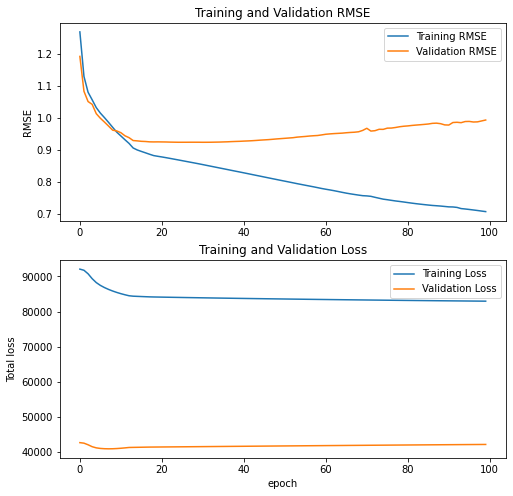

In [122]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

plotting_history(rmse, val_rmse, loss, val_loss)

# 4. Plotting the Embedding space

In [16]:
def tsne_movie_embeddings(model):
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  x = model.movie_model.layers[-1](tf.constant(list(range(len(unique_movie_titles)+1)))).numpy()
  print('Running t-SNE...')
  V_proj = tsne.fit_transform(x)
  return V_proj

In [48]:
V_proj = tsne_movie_embeddings(loaded_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1665 samples in 0.001s...
[t-SNE] Computed neighbors for 1665 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1665
[t-SNE] Computed conditional probabilities for sample 1665 / 1665
[t-SNE] Mean sigma: 0.250014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.141628
[t-SNE] KL divergence after 400 iterations: 1.534297


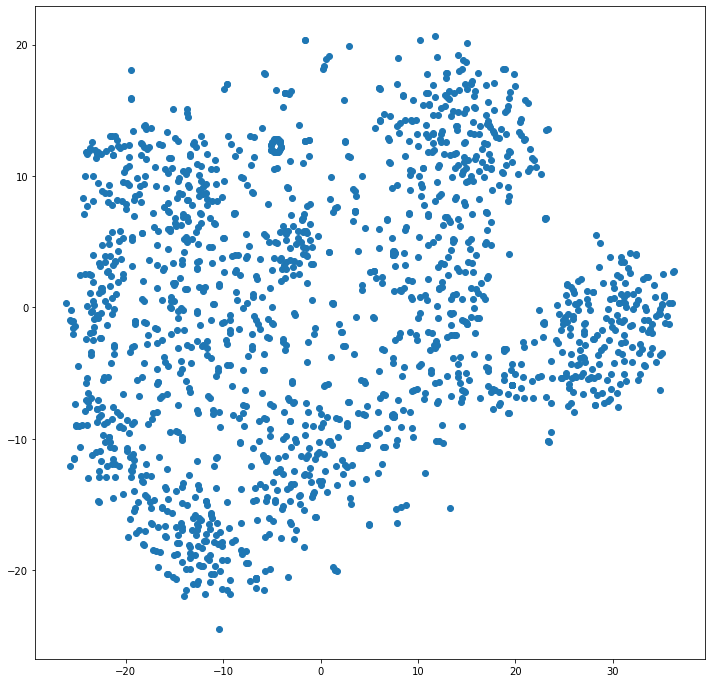

In [49]:
idx = list(range(50,60,1))

X = V_proj[:,0]
Y = V_proj[:,1]

# X = V_proj[50:60,0]
# Y = V_proj[50:60,1]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
# for i, x, y in zip(movies_df['movie_title'][idx], X, Y):
    # plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# 5. Model serving

In [9]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(loaded_model.user_model)
scann_index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(128), movies.batch(128).map(loaded_model.movie_model)))
)

ImportError: The scann library is not present. Please install it using `pip install scann` to use the ScaNN layer.

In [11]:
# Create a model that takes in raw query features, and
bf_index = tfrs.layers.factorized_top_k.BruteForce(loaded_model.user_model)
# recommends movies out of the entire movies dataset.
bf_index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(1128), movies.batch(1128).map(loaded_model.movie_model)))
)

AttributeError: 'BruteForce' object has no attribute 'index_from_dataset'

In [15]:
topK_index = tfrs.layers.factorized_top_k.TopK(loaded_model.user_model)
topK_index.index_from_dataset(tf.data.Dataset.zip((movies.batch(128), movies.batch(128).map(loaded_model.movie_model))))

TypeError: TopK() takes no arguments

In [54]:
# Get recommendations.
user = str(len(unique_user_ids)-40)
scores, titles = scann_index(tf.constant([user]))
bf_scores, bf_titles = bf_index(tf.constant([user]))
print(f"ScaNN Recommendations for user {user}: {titles[0, :10]}")
print(f'ScaNN Rating scores of user {user}: {scores[0, :10]}')
print('='*100)
print(f'Bruce force Recommendations for user {user}: {bf_titles[0, :10]}')
print(f'Bruce force Rating scores of user {user}: {bf_scores[0,:10]}')


ScaNN Recommendations for user 903: [b'He Walked by Night (1948)' b'Living in Oblivion (1995)'
 b'Alphaville (1965)' b'Funeral, The (1996)' b'Loaded (1994)'
 b'Trees Lounge (1996)' b'I Shot Andy Warhol (1996)' b'Party Girl (1995)'
 b'Crossing Guard, The (1995)' b'Some Folks Call It a Sling Blade (1993)']
ScaNN Rating scores of user 903: [3.4825175 3.3029656 3.2898133 3.2814198 3.2526917 3.1808712 3.152143
 3.1449609 3.1090508 2.937893 ]
Bruce force Recommendations for user 903: [b'Paris, Texas (1984)' b'Feeling Minnesota (1996)' b'Party Girl (1995)'
 b'I Shot Andy Warhol (1996)' b'Alphaville (1965)' b'Diabolique (1996)'
 b'Exotica (1994)' b'Living in Oblivion (1995)'
 b'Some Folks Call It a Sling Blade (1993)' b'Loaded (1994)']
Bruce force Rating scores of user 903: [4.122443  4.016645  3.7319243 3.5972507 3.5380466 3.5367215 3.5111067
 3.4400342 3.3804555 3.3462868]


In [55]:
ratings_df['user_id'].values

array([b'138', b'92', b'301', ..., b'262', b'911', b'276'], dtype=object)

In [179]:
user_ratings = ratings_df.pivot_table(index='user_id', columns='movie_title', values='user_rating', aggfunc='mean')
user_ratings.sort_values('user_id', ascending=True)
user_ratings.fillna(0.0, inplace=True)

###__Double check with ground truth__

In [182]:
user = f'b\'{str(len(unique_user_ids)-40)}\''
print(user)
a = user_ratings.index
print(a)

b'903'
Index([  b'1',  b'10', b'100', b'101', b'102', b'103', b'104', b'105', b'106',
       b'107',
       ...
        b'94', b'940', b'941', b'942', b'943',  b'95',  b'96',  b'97',  b'98',
        b'99'],
      dtype='object', name='user_id', length=943)
